### 1.1
1. Для классификации изображении применялась свёрточная сеть с полносвязным слоем, следующим за сверточной частью. Точность классификации: Train/Test: 0.859/0.832
2. В качестве другого варианта была использованна предобученная сеть resnet18 сопровождённая полносвязным слоем. Точность классификации: Train/Test: 0.982/0.949

### 1.2
Можно называть похожими на оба класса те объекты, на которых сеть ошибается. 

### 1.3
Для получение объектов похожих и на крокодила и на часы был применён следующий метод. Сначала обучается автоэнкодер, а затем для изображения часов и для изображения крокодила бралось из представление на скрытом слое, и бралась "точка" по-середине между этими скрытыми представлениями. Полученный вектор пропускался через оставшуюся часть автоенкодера.

## Возможные улучшения

### 1.1
1. Нужно перебрать большее число комбинаций различных регуляризующих слоёв (BatchNorm, Dropout, Dropconnect) и попробовать обучить более глубокую сеть
2. Так же можно попробовать подобрать правильную стратегию изменения learning rate

### 1.3
Т.к. разрешение исходных изображений невелико, то результат получается невпечатляющий, но можно попытаться улучшить качество автоенкодера за счёт изпользование более сложного функционала потерь (Добавить MSE между фильтрами некоторой предобученной сети, сквозь которую пропускается исходное изображение и оно же, пропущенное через автоэнкодер). Также можно использовать GAN-ы и генерировать изображения с помощью генератора, подавая ему на вход шум, и визуально выбирая наиболее интересные изображения.

In [60]:
import os.path
import sys
import math

from skimage import transform
from skimage.io import imread, imshow, imread_collection, concatenate_images

import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from PIL import Image

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import division

In [61]:
USE_CUDA = False
if torch.cuda.is_available():
    USE_CUDA = True

In [94]:
class Clock_Croc_Dataset(Dataset):
    def __init__(self, transform=None, train=True):
        self.transform = transform
        self.base_path = './clocks_crocodiles/'
        self.clock_base_path = './clock/'
        self.crocs_base_path = './crocodile/'
        self.train_test = None
        if train == True:
            self.train_test = './train/'
        else:
            self.train_test = './test/'
        
        self.clock_paths = []
        self.croc_paths = []

        def get_file_names(x, dir_name, files):
            x += files

        os.path.walk(self.base_path+self.clock_base_path+self.train_test, get_file_names, self.clock_paths)
        os.path.walk(self.base_path+self.crocs_base_path+self.train_test, get_file_names, self.croc_paths)

    def __len__(self):
        return len(self.clock_paths) + len(self.croc_paths)

    def __getitem__(self, idx):
        if idx < len(self.clock_paths):
            img_name = os.path.join(
                self.base_path,
                self.clock_base_path,
                self.train_test,
                self.clock_paths[idx]
            )
        else:
            img_name = os.path.join(
                self.base_path,
                self.crocs_base_path,
                self.train_test,
                self.croc_paths[idx - len(self.clock_paths)]
            )
        image = Image.open(img_name)
        sample = [image, long(idx > len(self.clock_paths))]

        if self.transform:
            sample[0] = self.transform(sample[0])

        return sample

In [95]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

dataset_test = Clock_Croc_Dataset(transform, train=False)
dataset_train = Clock_Croc_Dataset(transform, train=True)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

In [96]:
# nn.Conv2d: @in, @out, @k_size, ...

class Clock_Crock_Classifier(nn.Module):
    def __init__(self):
        super(Clock_Crock_Classifier, self).__init__()
        self.convl = nn.Sequential(
            nn.Conv2d(3, 9, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), 
            nn.Conv2d(9, 27, 3, padding=1)
        )
        self.linear = nn.Sequential(
            nn.BatchNorm1d((32 // 2) * (32 // 2) * 27),
            nn.Linear((32 // 2) * (32 // 2) * 27, 500),
            nn.ReLU(),
            nn.BatchNorm1d(500),
            nn.Linear(500, 2),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, X):
        X = self.convl(X)
        X = X.view(X.size(0), -1)
        X = self.linear(X)
        return X

In [100]:
model = Clock_Crock_Classifier()
loss = nn.NLLLoss()
if USE_CUDA:
    model = model.cuda()
    loss = loss.cuda()
    
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.8)

In [101]:
def train(network, loss, optimizer, scheduler, epochs, learning_rate, train_loader, test_loader):
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:

                X = Variable(X)
                y = Variable(y)
                if USE_CUDA:
                    X = X.cuda()
                    y = y.cuda()
                    
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                loss_batch.backward()
                optimizer.step()
                scheduler.step()
                
                losses.append(loss_batch.data[0])
                if USE_CUDA:
                    accuracies.append((np.argmax(prediction.cpu().data.numpy(), 1)==y.cpu().data.numpy()).mean())
                else:
                    accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())

                
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = Variable(X)
                y = Variable(y)
                if USE_CUDA:
                    X = X.cuda()
                    y = y.cuda()
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                
                losses.append(loss_batch.data[0])
                if USE_CUDA:
                    accuracies.append((np.argmax(prediction.cpu().data.numpy(), 1)==y.cpu().data.numpy()).mean())
                else:
                    accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

Epoch 249... (Train/Test) NLL: 0.317/0.386	Accuracy: 0.859/0.832

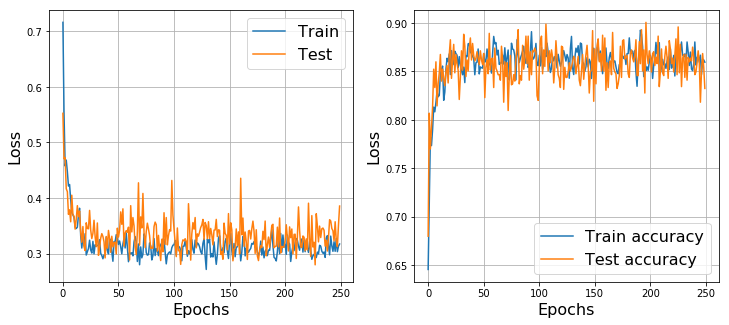

In [102]:
train(model, loss, optimizer, scheduler, 250, 0.001, dataloader_train, dataloader_test)

In [107]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X_, y in dataloader_test:
    X_ = Variable(X_)
    y = Variable(y)
    if USE_CUDA:
        X_ = X_.cuda()
        y = y.cuda()
    if USE_CUDA:
        prediction = model(X_).cpu().data.numpy()
    else:
        prediction = model(X_).data.numpy()
    X = []
    for x in X_:
        if USE_CUDA:
            X.append([np.array(transforms.ToPILImage()(x.cpu().data))])
        else:
            X.append([np.array(transforms.ToPILImage()(x.data))])
    if USE_CUDA:
        y = y.cpu().data.numpy()
    else:
        y = y.data.numpy()
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]

## Объекты, похожие на оба класса

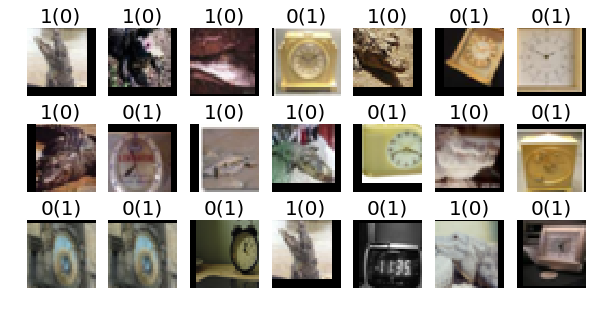

In [114]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for j, i in enumerate(np.random.randint(0, wrong_X.shape[0], 21)):
    plt.subplot(3, 7, j+1)
    plt.imshow(wrong_X[i])
    plt.title('{}({})'.format(correct_y[i], predicted_y[i]), fontsize=20)
    plt.axis('off')

# Transfer Learning

In [115]:
transform_resnet = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset_resnet_test = Clock_Croc_Dataset(transform=transform_resnet, train=False)
dataset_resnet_train = Clock_Croc_Dataset(transform=transform_resnet, train=True)
dataloader_resnet_test = DataLoader(dataset_resnet_test, batch_size=32, shuffle=True)
dataloader_resnet_train = DataLoader(dataset_resnet_train, batch_size=32, shuffle=True)

In [116]:
import torchvision.models as models

class Clock_Crock_Classifier_ResNet(nn.Module):
    def __init__(self):
        super(Clock_Crock_Classifier_ResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.linear = nn.Sequential(
            nn.Linear(1000, 2),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, X):
        X = self.resnet(X)
        X = X.view(X.size(0), -1)
        X = self.linear(X)
        return X

In [118]:
model_resnet = Clock_Crock_Classifier_ResNet()
loss_resnet = nn.NLLLoss()
if USE_CUDA:
    model_resnet = model_resnet.cuda()
    loss_resnet = loss_resnet.cuda()

optimizer_resnet = torch.optim.Adam(model_resnet.linear.parameters(), lr=0.01)
scheduler_resnet = torch.optim.lr_scheduler.StepLR(optimizer_resnet, step_size=30, gamma=0.8)

Epoch 9... (Train/Test) NLL: 0.075/0.360	Accuracy: 0.982/0.949

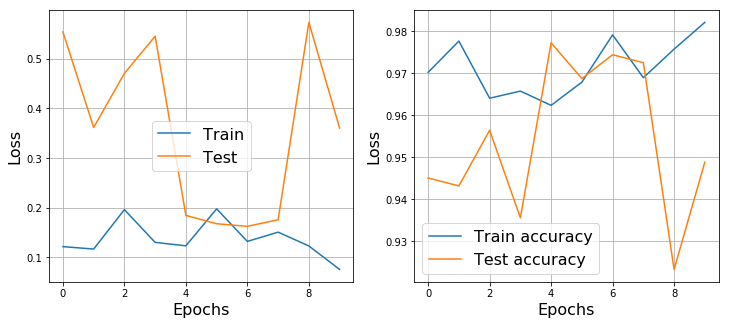

In [120]:
train(model_resnet, loss_resnet, optimizer_resnet, scheduler_resnet, 10, 0.01, dataloader_resnet_train, dataloader_resnet_test)

In [124]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X_, y in dataloader_resnet_test:
    X_ = Variable(X_)
    y = Variable(y)
    if USE_CUDA:
        X_ = X_.cuda()
        y = y.cuda()
    if USE_CUDA:
        prediction = model_resnet(X_).cpu().data.numpy()
    else:
        prediction = model_resnet(X_).data.numpy()
    X = []
    for x in X_:
        if USE_CUDA:
            X.append([np.array(transforms.ToPILImage()(x.cpu().data))])
        else:
            X.append([np.array(transforms.ToPILImage()(x.data))])
    if USE_CUDA:
        y = y.cpu().data.numpy()
    else:
        y = y.data.numpy()
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]

## Объекты, похожие на оба класса

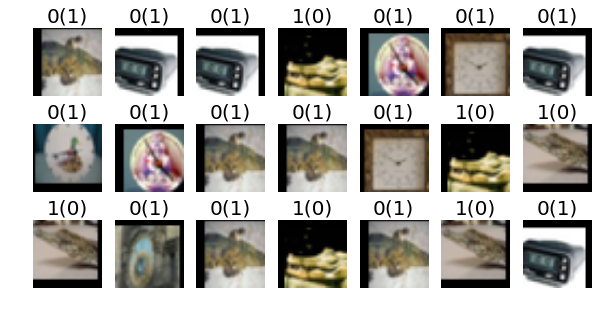

In [125]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for j, i in enumerate(np.random.randint(0, wrong_X.shape[0], 21)):
    plt.subplot(3, 7, j+1)
    plt.imshow(wrong_X[i])
    plt.title('{}({})'.format(correct_y[i], predicted_y[i]), fontsize=20)
    plt.axis('off')

# Simple AE

In [136]:
class Clock_Croc_Dataset_VAE(Clock_Croc_Dataset):
    def __init__(self, transform=None, train=True):
        super(Clock_Croc_Dataset_VAE, self).__init__(transform, train)
    def __getitem__(self, idx):
        X, _ = super(Clock_Croc_Dataset_VAE, self).__getitem__(idx)
        return X, X.clone()

In [137]:
class MSELoss_wrt_both(nn.MSELoss):
    def __init__(self):
        super(MSELoss_wrt_both, self).__init__()
        self.is_cuda = False

    def cuda(self):
        super(MSELoss_wrt_both, self).cuda()
        self.is_cuda = True
        
        return self
        
    def forward(self, inpt, target):
        diff = torch.sum((inpt - target)**2) / inpt.data.nelement()
        zeros = torch.zeros_like(diff)
        if self.is_cuda:
            zeros = zeros.cuda()
        return super(MSELoss_wrt_both, self).forward(diff, zeros)

In [227]:
class Simple_Clock_Croc_VAE(nn.Module):
    def __init__(self):
        super(Simple_Clock_Croc_VAE, self).__init__()
        self.modules_convl = [
            ['Conv2d_1',    nn.Conv2d(3, 9, 3, padding=1)],
            ['ReLU_1',      nn.ReLU()],
            ['MaxPool2d_1', nn.MaxPool2d(2, return_indices=True)],
            ['Conv2d_2',    nn.Conv2d(9, 27, 3, padding=1)]
        ]
        self.modules_deconvl = [
            ['ConvTranspose2d_1', nn.ConvTranspose2d(27, 9, 3, padding=1)],
            ['MaxUnpool2d_1',     nn.MaxUnpool2d(2)],
            ['ReLU_2',            nn.ReLU()],
            ['ConvTranspose2d_2', nn.ConvTranspose2d(9, 3, 3, padding=1)]
        ]
    
    def cuda(self):
        super(Simple_Clock_Croc_VAE, self).cuda()
        
        for _, module in self.modules_convl:
            module.cuda()
            
        for _, module in self.modules_deconvl:
            module.cuda()
        
        return self
    
    def weight_init(self):
        for name, module in self.modules_convl:
            for param_name, param in module.named_parameters():
                if name.find('Linear') != -1:
                    if param_name != 'bias':
                        param = nn.init.xavier_normal(param)
                elif name.find('Pool') != -1 or name.find('Unpool') != -1:
                    continue
                elif name.find('Conv') != -1:
                    if param_name != 'bias':
                        nn.init.xavier_uniform(param)

        for name, module in self.modules_deconvl:
            for param_name, param in module.named_parameters():
                if name.find('Linear') != -1:
                    if param_name != 'bias':
                        param = nn.init.xavier_normal(param)
                elif name.find('Pool') != -1 or name.find('Unpool') != -1:
                    continue
                elif name.find('Conv') != -1:
                    if param_name != 'bias':
                        nn.init.xavier_uniform(param)
            
    def zero_grad(self):
        super(Simple_Clock_Croc_VAE, self).zero_grad()
        
        self.hidden_states = []
        
        for _, module in self.modules_convl:
            module.zero_grad()
            
        for _, module in self.modules_deconvl:
            module.zero_grad()
    
    def parameters(self):
        super(Simple_Clock_Croc_VAE, self).parameters()
        for name, module in self.modules_convl:
            for param in module.parameters():
                yield param
            
        for name, module in self.modules_deconvl:
            for param in module.parameters():
                yield param
    
    def forward(self, X):
        indices = []
        for name, module in self.modules_convl:
            if name.find('Pool') != -1:
                X, index = module(X)
                indices.append([index])
            elif name.find('Linear') != -1:
                X = X.view(X.size(0), -1)
                X = module(X)
            else:
                X = module(X)
 
        ind_idx = len(indices) - 1
        for name, module in self.modules_deconvl:
            if name.find('Unpool') != -1:
                X = module(X, indices[ind_idx][0])
                ind_idx -= 1
            else:
                X = module(X)
            if name == 'Linear_3':
                X = X.view(X.size()[0], 16, 16, 16)
            
        return X
    def get_hidden_states(self):
        return self.hidden_states
    
    def get_latent_repres(self, X):
        indices = []
        for name, module in self.modules_convl:
            if name.find('Pool') != -1:
                X, index = module(X)
                indices.append([index])
            elif name.find('Linear') != -1:
                X = X.view(X.size(0), -1)
                X = module(X)
            else:
                X = module(X)
        return X, indices
    
    def transform_from_latent(self, X, indices):
        ind_idx = len(indices) - 1
        for name, module in self.modules_deconvl:
            if name.find('Unpool') != -1:
                X = module(X, indices[ind_idx][0])
                ind_idx -= 1
            else:
                X = module(X)
            if name == 'Linear_3':
                X = X.view(X.size()[0], 16, 16, 16)
        return X

In [228]:
def train_vae(network, loss, optimizer, epochs, learning_rate, train_loader, test_loader):
    train_loss_epochs = []
    test_loss_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            for X, y in train_loader:
                X = Variable(X)
                y = Variable(y)
                if USE_CUDA:
                    X = X.cuda()
                    y = y.cuda()
                
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                for left, right in network.get_hidden_states():  
                    loss_batch += loss(left, right)
                loss_batch.backward()
                optimizer.step()
                
                if USE_CUDA:
                    losses.append(loss_batch.cpu().data[0])
                else:
                    losses.append(loss_batch.data[0])

            train_loss_epochs.append(np.mean(losses))
            losses = []
            for X, y in test_loader:
                X = Variable(X)
                y = Variable(y)
                if USE_CUDA:
                    X = X.cuda()
                    y = y.cuda()
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                
                if USE_CUDA:
                    losses.append(loss_batch.cpu().data[0])
                else:
                    losses.append(loss_batch.data[0])
            test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.10f}/{2:.10f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')

In [229]:
transform_vae = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

dataset_vae_test = Clock_Croc_Dataset_VAE(transform_vae, train=False)
dataset_vae_train = Clock_Croc_Dataset_VAE(transform_vae, train=True)
dataloader_vae_test = DataLoader(dataset_vae_test, batch_size=32, shuffle=True)
dataloader_vae_train = DataLoader(dataset_vae_train, batch_size=32, shuffle=True)

In [230]:
model_vae = Simple_Clock_Croc_VAE()
model_vae.weight_init()
loss_vae = MSELoss_wrt_both()
if USE_CUDA:
    model_vae = model_vae.cuda()
    loss_vae = loss_vae.cuda()

In [231]:
optimizer_vae = torch.optim.Adam(model_vae.parameters(), lr=0.01)

Epoch 19... (Train/Test) NLL: 0.0000685952/0.0000657728

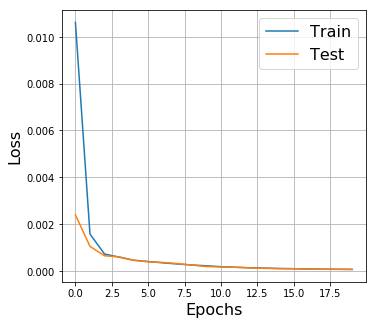

In [232]:
train_vae(model_vae, loss_vae, optimizer_vae, 20, 0.01, dataloader_vae_train, dataloader_vae_test)

In [413]:
def get_sample(dataloader):
    sample = None
    for X, y in dataloader:
        sample = X[0]
    if USE_CUDA:
        return sample.cuda()
    else:
        return sample

def plot_result_from_model(model, sample, draw_result=False):
    sample_v = Variable(sample.unsqueeze(0))
    if USE_CUDA:
        sample_v = model(sample_v)[0].cpu().data
        sample = sample.cpu()
    else:
        sample_v = model(sample_v)[0].data

    plt.figure(figsize=(10,10))

    plt.subplot(1,2,1)
    plt.imshow(np.array( transforms.ToPILImage()(sample)))
    
    if draw_result:
        plt.subplot(1,2,2)
        plt.imshow(np.array( transforms.ToPILImage()(sample_v) ))

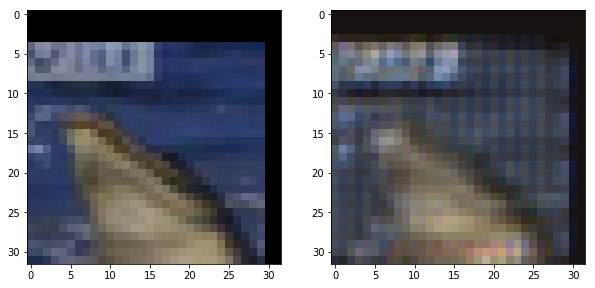

In [520]:
sample_one = get_sample(dataloader_vae_train)
plot_result_from_model(model_vae, sample_one, True)

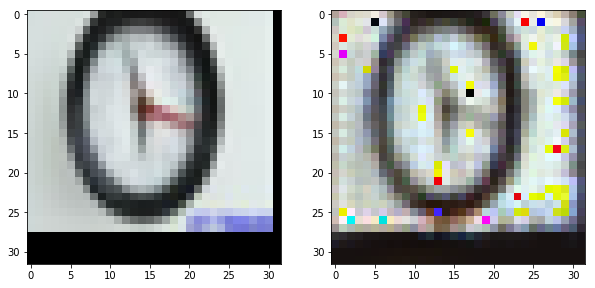

In [440]:
sample_two = get_sample(dataloader_vae_test)
plot_result_from_model(model_vae, sample_two, True)

In [521]:
latent_one, indices_one = model_vae.get_latent_repres(Variable(sample_one.view(1, sample_one.shape[0], sample_one.shape[1], sample_one.shape[2])).cuda())
latent_two, indices_two = model_vae.get_latent_repres(Variable(sample_two.view(1, sample_two.shape[0], sample_two.shape[1], sample_two.shape[2])).cuda())

# Картинка, похожая на обе картинки выше

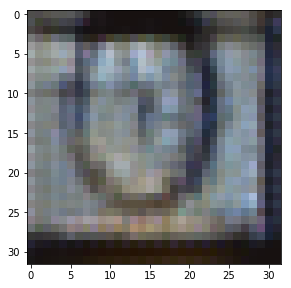

In [522]:
alpha = Variable(torch.Tensor([0.5])).cuda()
new_sample = alpha * latent_one + (1 - alpha) * latent_two
result = model_vae.transform_from_latent(new_sample, indices)
plot_result_from_model(model_vae, result.data[0], False)